<a href="https://colab.research.google.com/github/sayakpaul/Emotion-Detection-using-Deep-Learning/blob/master/Emotion_Detection_Using_Deep_Learning_ls_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Select TensorFlow 2.0 environment
%tensorflow_version 2.x

TensorFlow 2.x selected.


You need to get your API key from your Kaggle account to be able to proceed with the following. 

In [0]:
# Google Colab imports for setting up Kaggle
from google.colab import files
files.upload()

In [0]:
# Set up Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the data
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 26% 5.00M/19.3M [00:00<00:01, 12.7MB/s]
100% 19.3M/19.3M [00:00<00:00, 43.6MB/s]
 78% 72.0M/92.0M [00:01<00:00, 30.9MB/s]
100% 92.0M/92.0M [00:01<00:00, 54.5MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 18.1MB/s]
 76% 73.0M/96.6M [00:01<00:00, 42.0MB/s]
100% 96.6M/96.6M [00:01<00:00, 69.0MB/s]
 87% 67.0M/77.3M [00:01<00:00, 36.5MB/s]
100% 77.3M/77.3M [00:01<00:00, 56.9MB/s]


In [0]:
# Unzip dataset
!unzip -qq icml_face_data.csv.zip
!unzip -qq test.csv.zip
!unzip -qq train.csv.zip

In [0]:
# General imports
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
# Load up the training dataset
train = pd.read_csv("train.csv")
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
# Class distribution
train["emotion"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Class imbalance noticed.

In [9]:
# Load test dataset
test = pd.read_csv("test.csv")
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


Note on the label mapping:

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [0]:
# Function to clean the dataset
# Taken from http://bit.ly/37AUk7f
def clean_data(dataframe):
    image_pixels = np.zeros(shape=(len(dataframe), 48, 48))
    labels = np.zeros(shape=(len(dataframe), ))
    for (i, row) in tqdm(dataframe.iterrows()):
        image = np.fromstring(row["pixels"], dtype=int, sep=' ')
        image = image.reshape(48, 48)
        image = image.astype("float")/255
        
        image_pixels[i] = image
        labels[i] = row["emotion"]
    
    return (image_pixels, labels)

In [11]:
# Clean the training dataset and verify the shapes
(train_pixels, train_labels) = clean_data(train)
train_pixels.shape, train_labels.shape

28709it [00:05, 5601.70it/s]


((28709, 48, 48), (28709,))

In [0]:
# sklearn and other utility imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [0]:
# One-hot encode the labels
le = LabelEncoder().fit(train_labels)
train_labels = to_categorical(le.transform(train_labels), 7)

In [14]:
train_labels.shape

(28709, 7)

In [15]:
# Split the training data into further partial training and validation data
(trainX, valX, trainY, valY) = train_test_split(train_pixels,
    train_labels, test_size=0.15, stratify=train_labels, random_state=42)
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [16]:
# Serialize the data for later reproducibility
np.save("trainX.npy", trainX), np.save("trainY.npy", trainY)
np.save("valX.npy", valX), np.save("valY.npy", valY)

(None, None)

In [17]:
# Load it like this
trainX, trainY = np.load("trainX.npy"), np.load("trainY.npy")
valX, valY = np.load("valX.npy"), np.load("valY.npy")
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [0]:
# Account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [0]:
# Define the label mapping
LABELS = {
    0: "Angry", 
    1: "Disgust", 
    2: "Fear",
    3: "Happy", 
    4: "Sad", 
    5: "Surprise", 
    6: "Neutral"
}

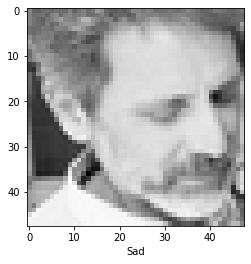

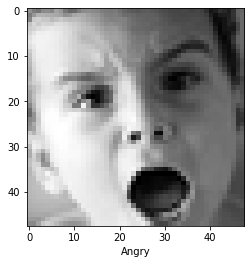

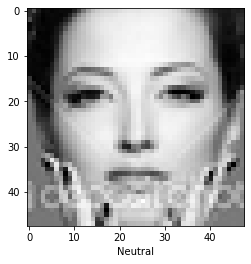

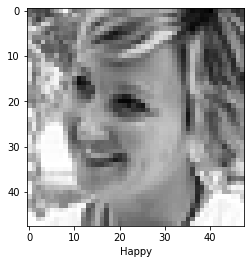

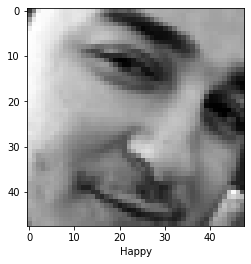

In [20]:
# Spot check the dataset
train_idx = np.random.choice(len(trainX), 5)
for id in train_idx:
    plt.imshow(trainX[id].reshape(48, 48), cmap="gray")
    plt.xlabel(LABELS[np.argmax(trainY[id])])
    plt.show()

For modeling purposes, we are going to use the following architecture:
- Mini VGGNet

For architectural details and discussions follow this article: https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/. 

In [21]:
# Comes from http://bit.ly/2U8ntCX
!wget https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/models.py

--2020-02-14 15:03:58--  https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5217 (5.1K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   5.09K  --.-KB/s    in 0s      

2020-02-14 15:03:58 (123 MB/s) - ‘models.py’ saved [5217/5217]



In [0]:
# PyImageSearch imports
from models import MiniVGGNetModel

In [0]:
# Convnets would require a channel dimension
trainX = trainX.reshape(-1, 48, 48, 1)
valX = valX.reshape(-1, 48, 48, 1)

In [0]:
# Set up wandb
!pip install wandb
!wandb login

In [0]:
# Import wandb
import wandb
from wandb.keras import WandbCallback

In [0]:
# To use Label Smoothing we need to use the CategoricalCrossentropy class
from tensorflow.keras.losses import CategoricalCrossentropy

In [29]:
# Train a mini VGG net with data augmentation, SGD & Label Smoothing
wandb.init(project="emotion-detection", entity="sayakpaul", id="vgg-net-sgd-ls")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss=CategoricalCrossentropy(label_smoothing=0.1), optimizer="sgd",
	metrics=["accuracy"])
vgg_net.fit(trainX, trainY,
    batch_size=64,
    validation_data=(valX, valY), 
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24192/24402 [============================>.] - ETA: 0s - loss: 2.2817 - accuracy: 0.2760

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


24402/24402 [==============================] - 14s 565us/sample - loss: 2.2785 - accuracy: 0.2767 - val_loss: 1.9800 - val_accuracy: 0.2610
Epoch 2/50
24402/24402 [==============================] - 5s 212us/sample - loss: 1.7522 - accuracy: 0.3887 - val_loss: 1.5828 - val_accuracy: 0.4472
Epoch 3/50
24402/24402 [==============================] - 5s 214us/sample - loss: 1.5944 - accuracy: 0.4396 - val_loss: 1.5570 - val_accuracy: 0.4586
Epoch 4/50
24402/24402 [==============================] - 5s 217us/sample - loss: 1.5153 - accuracy: 0.4767 - val_loss: 1.5286 - val_accuracy: 0.4662
Epoch 5/50
24402/24402 [==============================] - 5s 215us/sample - loss: 1.4674 - accuracy: 0.5016 - val_loss: 1.5028 - val_accuracy: 0.4813
Epoch 6/50
24402/24402 [==============================] - 5s 213us/sample - loss: 1.4223 - accuracy: 0.5235 - val_loss: 1.4717 - val_accuracy: 0.4950
Epoch 7/50
24402/24402 [==============================] - 5s 213us/sample - loss: 1.3937 - accuracy: 0.5366 - 

In [30]:
# Train a mini VGG net with data augmentation, SGD & Label Smoothing
wandb.init(project="emotion-detection", entity="sayakpaul", id="vgg-net-sgd-ls_0.2")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss=CategoricalCrossentropy(label_smoothing=0.2), optimizer="sgd",
	metrics=["accuracy"])
vgg_net.fit(trainX, trainY,
    batch_size=64,
    validation_data=(valX, valY), 
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24256/24402 [============================>.] - ETA: 0s - loss: 2.3410 - accuracy: 0.2596

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


24402/24402 [==============================] - 6s 254us/sample - loss: 2.3385 - accuracy: 0.2603 - val_loss: 1.8199 - val_accuracy: 0.3055
Epoch 2/50
24402/24402 [==============================] - 5s 216us/sample - loss: 1.8293 - accuracy: 0.3748 - val_loss: 1.6881 - val_accuracy: 0.4223
Epoch 3/50
24402/24402 [==============================] - 5s 215us/sample - loss: 1.6862 - accuracy: 0.4334 - val_loss: 1.6807 - val_accuracy: 0.4240
Epoch 4/50
24402/24402 [==============================] - 5s 218us/sample - loss: 1.6247 - accuracy: 0.4680 - val_loss: 1.6109 - val_accuracy: 0.4739
Epoch 5/50
24402/24402 [==============================] - 5s 217us/sample - loss: 1.5885 - accuracy: 0.4917 - val_loss: 1.7091 - val_accuracy: 0.4151
Epoch 6/50
24402/24402 [==============================] - 5s 219us/sample - loss: 1.5624 - accuracy: 0.5049 - val_loss: 1.6009 - val_accuracy: 0.4725
Epoch 7/50
24402/24402 [==============================] - 5s 219us/sample - loss: 1.5395 - accuracy: 0.5234 - v

In [31]:
# Train a mini VGG net with data augmentation, SGD & Label Smoothing
wandb.init(project="emotion-detection", entity="sayakpaul", id="vgg-net-sgd-ls_0.4")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss=CategoricalCrossentropy(label_smoothing=0.4), optimizer="sgd",
	metrics=["accuracy"])
vgg_net.fit(trainX, trainY,
    batch_size=64,
    validation_data=(valX, valY), 
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24384/24402 [============================>.] - ETA: 0s - loss: 2.4119 - accuracy: 0.2260

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


24402/24402 [==============================] - 6s 254us/sample - loss: 2.4120 - accuracy: 0.2260 - val_loss: 1.8949 - val_accuracy: 0.2988
Epoch 2/50
24402/24402 [==============================] - 5s 215us/sample - loss: 1.9870 - accuracy: 0.3187 - val_loss: 1.8275 - val_accuracy: 0.3866
Epoch 3/50
24402/24402 [==============================] - 5s 215us/sample - loss: 1.8611 - accuracy: 0.3802 - val_loss: 1.7983 - val_accuracy: 0.4258
Epoch 4/50
24402/24402 [==============================] - 5s 218us/sample - loss: 1.8131 - accuracy: 0.4146 - val_loss: 1.7869 - val_accuracy: 0.4365
Epoch 5/50
24402/24402 [==============================] - 5s 218us/sample - loss: 1.7890 - accuracy: 0.4385 - val_loss: 1.7858 - val_accuracy: 0.4404
Epoch 6/50
24402/24402 [==============================] - 5s 217us/sample - loss: 1.7726 - accuracy: 0.4569 - val_loss: 1.7800 - val_accuracy: 0.4507
Epoch 7/50
24402/24402 [==============================] - 5s 219us/sample - loss: 1.7607 - accuracy: 0.4682 - v

In [32]:
# Train a mini VGG net with data augmentation, SGD & Label Smoothing
wandb.init(project="emotion-detection", entity="sayakpaul", id="vgg-net-sgd-ls_0.7")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss=CategoricalCrossentropy(label_smoothing=0.7), optimizer="sgd",
	metrics=["accuracy"])
vgg_net.fit(trainX, trainY,
    batch_size=64,
    validation_data=(valX, valY), 
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24256/24402 [============================>.] - ETA: 0s - loss: 2.5085 - accuracy: 0.1901

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


24402/24402 [==============================] - 6s 249us/sample - loss: 2.5069 - accuracy: 0.1903 - val_loss: 1.9444 - val_accuracy: 0.2540
Epoch 2/50
24402/24402 [==============================] - 5s 214us/sample - loss: 2.0991 - accuracy: 0.2308 - val_loss: 1.9244 - val_accuracy: 0.3487
Epoch 3/50
24402/24402 [==============================] - 5s 213us/sample - loss: 1.9795 - accuracy: 0.2796 - val_loss: 1.9172 - val_accuracy: 0.3812
Epoch 4/50
24402/24402 [==============================] - 5s 219us/sample - loss: 1.9386 - accuracy: 0.3304 - val_loss: 1.9156 - val_accuracy: 0.3942
Epoch 5/50
24402/24402 [==============================] - 5s 217us/sample - loss: 1.9241 - accuracy: 0.3564 - val_loss: 1.9148 - val_accuracy: 0.3875
Epoch 6/50
24402/24402 [==============================] - 5s 215us/sample - loss: 1.9176 - accuracy: 0.3751 - val_loss: 1.9102 - val_accuracy: 0.3993
Epoch 7/50
24402/24402 [==============================] - 5s 219us/sample - loss: 1.9146 - accuracy: 0.3864 - v